In [1]:
%matplotlib widget
import torch
import numpy as np
import torch.optim as optim
from simple_pinn import SimplePINN
import matplotlib.pyplot as plt

In [2]:
model = SimplePINN(1, [20, 20, 20], 1)
print(model)

SimplePINN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
  )
  (head): Linear(in_features=20, out_features=1, bias=True)
)


In [3]:
R = 1.0  # rate of maximum population growth parameterizing the equation
X_BOUNDARY = 0.0  # boundary condition coordinate
F_BOUNDARY = 0.5  # boundary condition value
DOMAIN = (-5.0, 5.0)  # x boundaries of the problem

analytical_sol_fn = lambda x: 1.0 / (1.0 + (1.0 / F_BOUNDARY - 1.0) * np.exp(-R * x))

In [4]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 100
n_epochs = 1000

In [5]:
def compute_loss(x, y, model):
    dy_dx = torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]
    residual = dy_dx - R * y * (1.0 - y)
    residual_loss = torch.mean(torch.square(residual))
    boundary_value = model(torch.tensor([X_BOUNDARY]))
    boundary_loss = torch.mean(
        torch.square(boundary_value - torch.tensor([F_BOUNDARY]))
    )
    return residual_loss + boundary_loss

In [6]:
for epoch in range(n_epochs):
    x = (
        torch.rand(batch_size, 1, requires_grad=True) * (DOMAIN[1] - DOMAIN[0])
        + DOMAIN[0]
    )
    y = model(x)
    loss = compute_loss(x, y, model)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1} | Loss: {loss.item():.6f}")

Epoch 1 | Loss: 0.059241
Epoch 2 | Loss: 0.050591
Epoch 3 | Loss: 0.050478
Epoch 4 | Loss: 0.049531
Epoch 5 | Loss: 0.047659
Epoch 6 | Loss: 0.045564
Epoch 7 | Loss: 0.041339
Epoch 8 | Loss: 0.039172
Epoch 9 | Loss: 0.035045
Epoch 10 | Loss: 0.031205
Epoch 11 | Loss: 0.028416
Epoch 12 | Loss: 0.035105
Epoch 13 | Loss: 0.026306
Epoch 14 | Loss: 0.028604
Epoch 15 | Loss: 0.026466
Epoch 16 | Loss: 0.020617
Epoch 17 | Loss: 0.021221
Epoch 18 | Loss: 0.020843
Epoch 19 | Loss: 0.020372
Epoch 20 | Loss: 0.017793
Epoch 21 | Loss: 0.017624
Epoch 22 | Loss: 0.015997
Epoch 23 | Loss: 0.014194
Epoch 24 | Loss: 0.013277
Epoch 25 | Loss: 0.011491
Epoch 26 | Loss: 0.009970
Epoch 27 | Loss: 0.008593
Epoch 28 | Loss: 0.006661
Epoch 29 | Loss: 0.006081
Epoch 30 | Loss: 0.004873
Epoch 31 | Loss: 0.003967
Epoch 32 | Loss: 0.003570
Epoch 33 | Loss: 0.002372
Epoch 34 | Loss: 0.001881
Epoch 35 | Loss: 0.001411
Epoch 36 | Loss: 0.001262
Epoch 37 | Loss: 0.000720
Epoch 38 | Loss: 0.000684
Epoch 39 | Loss: 0.00

In [7]:
x_eval = torch.linspace(DOMAIN[0], DOMAIN[1], steps=101).reshape(-1, 1)
y_eval = model(x_eval)
y_true = analytical_sol_fn(x_eval.detach().numpy())

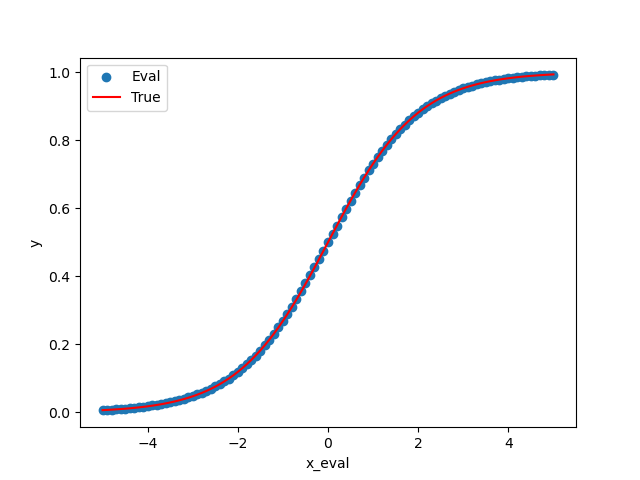

In [8]:
plt.figure()
plt.scatter(x_eval, y_eval.detach().numpy(), label="Eval", marker="o")
plt.plot(x_eval, y_true, label="True", color="red")
plt.xlabel("x_eval")
plt.ylabel("y")
plt.legend(loc="best")
plt.show()